In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# 데이터 로드

In [ ]:
# 리뷰 데이터 분석 후 결과값 df 로드('result_df_3'로 지정)
result_df_4 = pd.read_csv("result_df_4.csv")

In [ ]:
result_df_4.shape

(94525, 29)

In [ ]:
len(set(result_df_4['goodsNo']))

318

In [ ]:
# 모든 사이즈 정보 값 0인 케이스(1개) 제거
result_df_4 = result_df_4[result_df_4['shoulder'] != 0]

# FREE 사이즈 제거(리뷰 수 906개 제거(상품3개 삭제, 상품1개 리뷰 7개삭제))
result_df_4 = result_df_4[result_df_4['size'] != 'FREE']

In [ ]:
result_df_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93618 entries, 0 to 94524
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review          93618 non-null  object 
 1   id              93618 non-null  object 
 2   goodsNo         93618 non-null  int64  
 3   brandNameEng    93618 non-null  object 
 4   goodsName       93618 non-null  object 
 5   imageUrl        93618 non-null  object 
 6   reviewScore     93618 non-null  int64  
 7   typeClass       93618 non-null  object 
 8   cate            93618 non-null  object 
 9   size            93618 non-null  object 
 10  length          93618 non-null  float64
 11  shoulder        87959 non-null  float64
 12  chest           93618 non-null  float64
 13  sleeve          93618 non-null  float64
 14  date            93618 non-null  object 
 15  grade           93618 non-null  object 
 16  gender          93618 non-null  object 
 17  height          93618 non-null  int6

In [ ]:
# null 값이 존재하는 행 삭제 전의 행 개수
initial_row_count = result_df_4.shape[0]

# null 값이 존재하는 행 삭제
columns_to_check = ['length', 'shoulder', 'chest', 'sleeve']
result_df_4 = result_df_4.dropna(subset=columns_to_check)

# null 값이 존재하는 행 삭제 후의 행 개수
final_row_count = result_df_4.shape[0]

# 삭제된 행의 개수
deleted_rows = initial_row_count - final_row_count

print(f"삭제된 행의 개수: {deleted_rows}")

삭제된 행의 개수: 5659


In [ ]:
result_df_4.shape

(87959, 29)

In [ ]:
result_df_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87959 entries, 0 to 94524
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review          87959 non-null  object 
 1   id              87959 non-null  object 
 2   goodsNo         87959 non-null  int64  
 3   brandNameEng    87959 non-null  object 
 4   goodsName       87959 non-null  object 
 5   imageUrl        87959 non-null  object 
 6   reviewScore     87959 non-null  int64  
 7   typeClass       87959 non-null  object 
 8   cate            87959 non-null  object 
 9   size            87959 non-null  object 
 10  length          87959 non-null  float64
 11  shoulder        87959 non-null  float64
 12  chest           87959 non-null  float64
 13  sleeve          87959 non-null  float64
 14  date            87959 non-null  object 
 15  grade           87959 non-null  object 
 16  gender          87959 non-null  object 
 17  height          87959 non-null  int6

In [ ]:
data_df = result_df_4.copy()

In [ ]:
data_df.shape

(87959, 29)

In [ ]:
# 최종 사용하는 상품 개수
len(set(data_df['goodsNo']))

296

In [ ]:
selected_columns = ['goodsNo','size', 'length', 'shoulder', 'chest', 'sleeve']
data_df[selected_columns]

,goodsNo,size,length,shoulder,chest,sleeve
0,2151608,105,73.0,51.0,57.5,64.5
1,3603793,M,69.0,54.0,59.0,59.0
2,3134802,XXXL,74.5,60.5,66.5,59.0
3,2995104,S,65.0,65.0,66.0,52.0
5,1190282,XL,74.0,51.5,59.0,60.5
...,...,...,...,...,...,...
94520,3481226,L,72.3,50.0,57.0,59.0
94521,3481226,M,70.8,48.5,54.5,58.0
94522,3481227,XL,73.8,51.5,59.5,60.0
94523,3481226,L,72.3,50.0,57.0,59.0


# 리뷰 분석 후 전체, 총장, 어깨너비, 가슴둘레, 소매길이 조정 방향값 컬럼 10개에서 5개로 조정

- 'total_b_s', 'length_b_s', 'shoulder_b_s', 'chest_b_s', 'sleeve_b_s'로 지정

In [ ]:
# 조건 1: 'total_big'이랑 'total_small'에 1이 하나라도 존재하고, 나머지가 모두 0인 경우
condition_1 = ((data_df['total_big'] == 1) | (data_df['total_small'] == 1)) & \
              (data_df[['length_big', 'length_small', 'shoulder_big', 'shoulder_small', 'chest_big', 'chest_small', 'sleeve_big', 'sleeve_small']] == 0).all(axis=1)

# 조건 2: 'total_big'이랑 'total_small'이 모두 0이고, 나머지 중에 하나라도 1이 존재하는 경우
condition_2 = (data_df['total_big'] == 0) & (data_df['total_small'] == 0) & \
              (data_df[['length_big', 'length_small', 'shoulder_big', 'shoulder_small', 'chest_big', 'chest_small', 'sleeve_big', 'sleeve_small']] == 1).any(axis=1)

# 조건 3: 모든 값이 0인 경우
condition_3 = (data_df[['total_big', 'total_small', 'length_big', 'length_small', 'shoulder_big', 'shoulder_small', 'chest_big', 'chest_small', 'sleeve_big', 'sleeve_small']] == 0).all(axis=1)

# 각 조건을 만족하는 데이터프레임의 개수 구하기
count_condition_1 = data_df[condition_1].shape[0]
count_condition_2 = data_df[condition_2].shape[0]
count_condition_3 = data_df[condition_3].shape[0]

print("조건 1을 만족하는 데이터의 개수:", count_condition_1)
print("조건 2을 만족하는 데이터의 개수:", count_condition_2)
print("조건 3을 만족하는 데이터의 개수:", count_condition_3)

조건 1을 만족하는 데이터의 개수: 4689
조건 2을 만족하는 데이터의 개수: 1539
조건 3을 만족하는 데이터의 개수: 81074


In [ ]:
data_df.head(1)

,review,id,goodsNo,brandNameEng,goodsName,imageUrl,reviewScore,typeClass,cate,size,...,total_big,total_small,length_big,length_small,shoulder_big,shoulder_small,chest_big,chest_small,sleeve_big,sleeve_small
0,"가, 겨 대비 품질 이 괜찮습니다 재구매, 의사 있습니다",안목있는칠레모던,2151608,BASIC HOUSE,[UNI]순면 고밀도 긴팔 티셔츠2팩 LATS0102,https://image.msscdn.net/thumbnails/images/goo...,95,보통이에요,longs,105,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_df.shape

(87959, 29)

In [ ]:
# 조건 1: total_big과 total_small이 동시에 1인 경우
condition_1 = (data_df['total_big'] == 1) & (data_df['total_small'] == 1)

# 조건 2: length_big과 length_small이 동시에 1인 경우
condition_2 = (data_df['length_big'] == 1) & (data_df['length_small'] == 1)

# 조건 3: shoulder_big과 shoulder_small이 동시에 1인 경우
condition_3 = (data_df['shoulder_big'] == 1) & (data_df['shoulder_small'] == 1)

# 조건 4: chest_big과 chest_small이 동시에 1인 경우
condition_4 = (data_df['chest_big'] == 1) & (data_df['chest_small'] == 1)

# 조건 5: sleeve_big과 sleeve_small이 동시에 1인 경우
condition_5 = (data_df['sleeve_big'] == 1) & (data_df['sleeve_small'] == 1)

# 모든 조건을 결합하여 필터링
filtered_df = data_df[condition_1 | condition_2 | condition_3 | condition_4 | condition_5]

# 결과 확인
filtered_df.shape

(245, 29)

In [ ]:
# DataFrame 복사
df = data_df.copy()

# 새로운 컬럼 계산 및 추가
df.loc[:, 'total_b_s'] = df['total_big'] - df['total_small']
df.loc[:, 'length_b_s'] = df['length_big'] - df['length_small']
df.loc[:, 'shoulder_b_s'] = df['shoulder_big'] - df['shoulder_small']
df.loc[:, 'chest_b_s'] = df['chest_big'] - df['chest_small']
df.loc[:, 'sleeve_b_s'] = df['sleeve_big'] - df['sleeve_small']

# 기존 컬럼 삭제
columns_to_drop = [
    'total_big', 'total_small', 'length_big', 'length_small',
    'shoulder_big', 'shoulder_small', 'chest_big', 'chest_small',
    'sleeve_big', 'sleeve_small'
]
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
df.head(1)

,review,id,goodsNo,brandNameEng,goodsName,imageUrl,reviewScore,typeClass,cate,size,...,date,grade,gender,height,weight,total_b_s,length_b_s,shoulder_b_s,chest_b_s,sleeve_b_s
0,"가, 겨 대비 품질 이 괜찮습니다 재구매, 의사 있습니다",안목있는칠레모던,2151608,BASIC HOUSE,[UNI]순면 고밀도 긴팔 티셔츠2팩 LATS0102,https://image.msscdn.net/thumbnails/images/goo...,95,보통이에요,longs,105,...,2023.10.28,LV.4,남성,174,69,0,0,0,0,0


In [ ]:
df.columns

Index(['review', 'id', 'goodsNo', 'brandNameEng', 'goodsName', 'imageUrl',
       'reviewScore', 'typeClass', 'cate', 'size', 'length', 'shoulder',
       'chest', 'sleeve', 'date', 'grade', 'gender', 'height', 'weight',
       'total_b_s', 'length_b_s', 'shoulder_b_s', 'chest_b_s', 'sleeve_b_s'],
      dtype='object')

In [ ]:
df.shape

(87959, 24)

# 'typeClass' 형태 변환 -> 분류성능평가지표에서 정답으로 활용
- 전체리뷰가 +-1이고, 나머지 길이 지표의 값이 0일 경우 +-1값으로 모두 변경

In [ ]:
# typeClass 값을 수치값으로 변경하는 함수 정의
def convert_type_class(value):
    if value == '커요':
        return 1
    elif value == '보통이에요':
        return 0
    elif value == '작아요':
        return -1
    else:
        return 0  # 'x'는 '보통이에요'처리

# typeClass 값을 변환
df['typeClass'] = df['typeClass'].apply(convert_type_class)

In [ ]:
# # total_b_s를 length_b_s, shoulder_b_s, chest_b_s, sleeve_b_s에 업데이트하는 함수 정의
# def update_b_s_values(row):
#     if row['total_b_s'] == 1 and row['length_b_s'] == 0 and row['shoulder_b_s'] == 0 and row['chest_b_s'] == 0 and row['sleeve_b_s'] == 0:
#         row['length_b_s'] = row['total_b_s']
#         row['shoulder_b_s'] = row['total_b_s']
#         row['chest_b_s'] = row['total_b_s']
#         row['sleeve_b_s'] = row['total_b_s']
#     elif row['total_b_s'] == -1 and row['length_b_s'] == 0 and row['shoulder_b_s'] == 0 and row['chest_b_s'] == 0 and row['sleeve_b_s'] == 0:
#         row['length_b_s'] = row['total_b_s']
#         row['shoulder_b_s'] = row['total_b_s']
#         row['chest_b_s'] = row['total_b_s']
#         row['sleeve_b_s'] = row['total_b_s']
#     return row

# # 필터링된 데이터프레임에 함수를 적용하여 값을 업데이트
# df = df.apply(update_b_s_values, axis=1)

In [ ]:
df.head(2)

,review,id,goodsNo,brandNameEng,goodsName,imageUrl,reviewScore,typeClass,cate,size,...,date,grade,gender,height,weight,total_b_s,length_b_s,shoulder_b_s,chest_b_s,sleeve_b_s
0,"가, 겨 대비 품질 이 괜찮습니다 재구매, 의사 있습니다",안목있는칠레모던,2151608,BASIC HOUSE,[UNI]순면 고밀도 긴팔 티셔츠2팩 LATS0102,https://image.msscdn.net/thumbnails/images/goo...,95,0,longs,105,...,2023.10.28,LV.4,남성,174,69,0,0,0,0,0
1,"가, 기본 아이템 으로 좋다고 하더니, 아주 마음 에 들어요, 네이비 도 정직한 네...",바람직한검정힐,3603793,LEE,[22FW] 빅 트위치 루즈핏 맨투맨 NAVY,https://image.msscdn.net/thumbnails/images/goo...,97,1,man2man,M,...,2024.04.13,LV.4,여성,163,48,0,0,0,0,0


In [ ]:
# 조건 1: total_big과 total_small이 동시에 1인 경우
condition_1 = (df['total_b_s'] == 1)

# 조건 2: length_big과 length_small이 동시에 1인 경우
condition_2 = (df['length_b_s'] == 1)

# 조건 3: shoulder_big과 shoulder_small이 동시에 1인 경우
condition_3 = (df['shoulder_b_s'] == 1)

# 조건 4: chest_big과 chest_small이 동시에 1인 경우
condition_4 = (df['chest_b_s'] == 1)

# 조건 5: sleeve_big과 sleeve_small이 동시에 1인 경우
condition_5 = (df['sleeve_b_s'] == 1)

# 모든 조건을 결합하여 필터링
filtered_df = df[condition_2 & condition_3 & condition_4 & condition_5]

# 결과 확인
filtered_df.shape

(0, 24)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87959 entries, 0 to 94524
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review        87959 non-null  object 
 1   id            87959 non-null  object 
 2   goodsNo       87959 non-null  int64  
 3   brandNameEng  87959 non-null  object 
 4   goodsName     87959 non-null  object 
 5   imageUrl      87959 non-null  object 
 6   reviewScore   87959 non-null  int64  
 7   typeClass     87959 non-null  int64  
 8   cate          87959 non-null  object 
 9   size          87959 non-null  object 
 10  length        87959 non-null  float64
 11  shoulder      87959 non-null  float64
 12  chest         87959 non-null  float64
 13  sleeve        87959 non-null  float64
 14  date          87959 non-null  object 
 15  grade         87959 non-null  object 
 16  gender        87959 non-null  object 
 17  height        87959 non-null  int64  
 18  weight        87959 non-null  i

# 분류성능평가

In [ ]:
# 각 변수들의 합을 구하고, 그 값에 따라 크기 변화 예측
df['sum_b_s'] = df[['length_b_s', 'shoulder_b_s', 'chest_b_s', 'sleeve_b_s']].sum(axis=1)
df['predicted_typeClass'] = df['sum_b_s'].apply(lambda x: 1 if x > 0 else (0 if x == 0 else -1))

# 실제 typeClass 값을 크기에 따라 변경 (1, 0, -1)
df['actual_typeClass'] = df['typeClass'].apply(lambda x: 1 if x > 0 else (0 if x == 0 else -1))

# 성능 평가
accuracy = accuracy_score(df['actual_typeClass'], df['predicted_typeClass'])

# 결과 출력
print(f"Accuracy: {accuracy}")

Accuracy: 0.7656635477893109


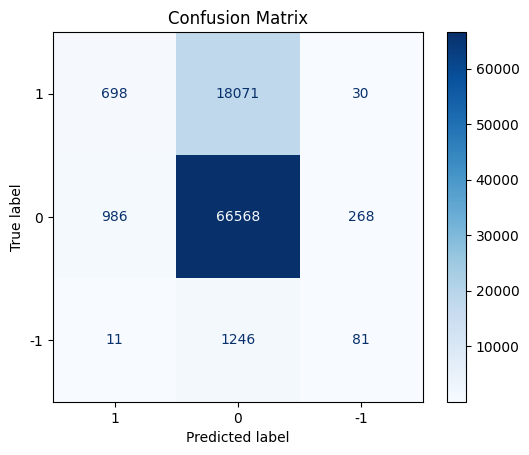

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
# 혼동 행렬 계산
cm = confusion_matrix(df['actual_typeClass'], df['predicted_typeClass'], labels=[1, 0, -1])

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0, -1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# typeClass는 큰데, 리뷰 언급은 보통인 경우가 많아서 성능이 떨어짐

# goodsNo 기준으로 각각의 리뷰 값들을 합치고 리뷰 데이터 수만큼 나누기/typeClass도 마찬가지로 진행

In [ ]:
# goodsNo 기준으로 방향값들의 합을 구함('b_s_sum_df'로 지정)
columns_to_add = ['length_b_s', 'shoulder_b_s', 'chest_b_s', 'sleeve_b_s']
b_s_sum_df = df.groupby('goodsNo')[columns_to_add].sum().reset_index()

In [ ]:
# goodsNo별 개수 계산
goodsNo_counts = df['goodsNo'].value_counts().reset_index()
goodsNo_counts.columns = ['goodsNo', 'sum_review']

# test_sum_df와 goodsNo_counts를 병합
b_s_sum_df = pd.merge(b_s_sum_df, goodsNo_counts, on='goodsNo', how='left')

In [ ]:
b_s_sum_df.head(2)

,goodsNo,length_b_s,shoulder_b_s,chest_b_s,sleeve_b_s,sum_review
0,394585,4,0,0,9,300
1,394608,5,2,1,6,300


In [ ]:
# 각 컬럼을 sum_review로 나누기
columns_to_divide = ['length_b_s', 'shoulder_b_s', 'chest_b_s', 'sleeve_b_s']
for column in columns_to_divide:
    b_s_sum_df[column] = b_s_sum_df[column] / b_s_sum_df['sum_review']

# sum_review 컬럼은 이제 필요없으므로 제거
b_s_sum_df.drop('sum_review', axis=1, inplace=True)

In [ ]:
b_s_sum_df.head(2)

,goodsNo,length_b_s,shoulder_b_s,chest_b_s,sleeve_b_s
0,394585,0.013333,0.000000,0.000000,0.03
1,394608,0.016667,0.006667,0.003333,0.02


In [ ]:
b_s_sum_df.shape

(296, 5)

# 상품 별로 모든 사이즈값들을 묶어서 리스트 저장

In [ ]:
# size, length, shoulder, chest, sleeve 값을 리스트로 묶어서 각 goodsNo에 대해 중복값 제거 후 저장
def aggregate_features(group):
    unique_values = group.drop_duplicates(subset=['size', 'length', 'shoulder', 'chest', 'sleeve'])
    return unique_values[['size', 'length', 'shoulder', 'chest', 'sleeve']].values.tolist()

# groupby를 사용하여 goodsNo 기준으로 집계('size_total_df'로 지정)
size_total_df = df.groupby('goodsNo').apply(aggregate_features).reset_index(name='size_total')

In [ ]:
size_total_df

,goodsNo,size_total
0,394585,"[[M, 73.0, 56.0, 58.0, 60.0], [L, 76.0, 60.0, ..."
1,394608,"[[L, 76.0, 60.0, 61.0, 62.0], [M, 73.0, 56.0, ..."
2,404474,"[[M, 72.5, 51.0, 55.5, 59.0], [XL, 76.5, 55.0,..."
3,404482,"[[M, 72.5, 51.0, 55.5, 59.0], [XL, 76.5, 55.0,..."
4,407066,"[[XXL, 76.5, 54.0, 62.5, 63.0], [M, 72.5, 49.5..."
...,...,...
291,3877002,"[[M, 78.0, 58.5, 68.0, 61.0], [L, 80.0, 60.5, ..."
292,3884711,"[[M, 75.0, 55.0, 59.0, 59.5], [XL, 79.0, 59.0,..."
293,4047283,"[[S, 68.0, 47.0, 64.0, 23.0], [M, 70.0, 49.0, ..."
294,4073506,"[[L, 79.0, 58.0, 66.0, 58.0], [XL, 81.0, 60.0,..."


In [ ]:
size_total_df.shape

(296, 2)

# 상품 별 총장, 어깨, 가슴, 소매 값들의 gap 최빈값 확인

In [ ]:
# 차이를 계산하여 고유값을 얻는 함수 (최빈값을 구하기 위한 함수로 수정)
def calculate_mode(values):
    if len(values) == 0:
        return None
    freq = Counter(values)
    max_freq = max(freq.values())
    modes = [key for key, value in freq.items() if value == max_freq]
    return modes

# 차이를 계산하여 고유값을 얻는 함수 (차이값들을 구하고 최빈값을 찾아서 반환)
def calculate_unique_gaps(size_data, index):
    # index에 따른 값을 추출
    values = sorted([size[index] for size in size_data])
    gaps = [round(values[i+1] - values[i], 2) for i in range(len(values)-1)]
    unique_gaps = calculate_mode(gaps)
    return unique_gaps

# 새로운 컬럼을 추가하는 함수
def add_gap_columns(row):
    size_data = row['size_total']
    row['length_gap_mode'] = calculate_unique_gaps(size_data, 1)
    row['shoulder_gap_mode'] = calculate_unique_gaps(size_data, 2)
    row['chest_gap_mode'] = calculate_unique_gaps(size_data, 3)
    row['sleeve_gap_mode'] = calculate_unique_gaps(size_data, 4)
    return row

# 데이터프레임에 새로운 컬럼 추가('gap_mode_df'로 지정)
gap_mode_df = size_total_df.apply(add_gap_columns, axis=1)
gap_mode_df

,goodsNo,size_total,length_gap_mode,shoulder_gap_mode,chest_gap_mode,sleeve_gap_mode
0,394585,"[[M, 73.0, 56.0, 58.0, 60.0], [L, 76.0, 60.0, ...",[3.0],[4.0],[2.0],[2.0]
1,394608,"[[L, 76.0, 60.0, 61.0, 62.0], [M, 73.0, 56.0, ...",[3.0],[4.0],[3.0],[2.0]
2,404474,"[[M, 72.5, 51.0, 55.5, 59.0], [XL, 76.5, 55.0,...",[2.0],[2.0],[2.5],[0.5]
3,404482,"[[M, 72.5, 51.0, 55.5, 59.0], [XL, 76.5, 55.0,...",[2.0],[2.0],[2.5],[0.5]
4,407066,"[[XXL, 76.5, 54.0, 62.5, 63.0], [M, 72.5, 49.5...",[1.5],[1.5],[2.5],[1.0]
...,...,...,...,...,...,...
291,3877002,"[[M, 78.0, 58.5, 68.0, 61.0], [L, 80.0, 60.5, ...",[2.0],[2.0],[2.0],[1.0]
292,3884711,"[[M, 75.0, 55.0, 59.0, 59.5], [XL, 79.0, 59.0,...",[2.0],[2.0],[2.5],[1.0]
293,4047283,"[[S, 68.0, 47.0, 64.0, 23.0], [M, 70.0, 49.0, ...",[2.0],[2.0],[2.0],[1.0]
294,4073506,"[[L, 79.0, 58.0, 66.0, 58.0], [XL, 81.0, 60.0,...",[2.0],[2.0],"[2.0, 3.0]",[1.0]


In [ ]:
gap_mode_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   goodsNo            296 non-null    int64 
 1   size_total         296 non-null    object
 2   length_gap_mode    296 non-null    object
 3   shoulder_gap_mode  296 non-null    object
 4   chest_gap_mode     296 non-null    object
 5   sleeve_gap_mode    296 non-null    object
dtypes: int64(1), object(5)
memory usage: 14.0+ KB


In [ ]:
# 각 컬럼별로 null 값을 가진 행을 확인
null_indices = gap_mode_df[gap_mode_df['length_gap_mode'].isnull() |
                           gap_mode_df['shoulder_gap_mode'].isnull() |
                           gap_mode_df['chest_gap_mode'].isnull() |
                           gap_mode_df['sleeve_gap_mode'].isnull()].index

# null 값을 가지는 상품의 goodsNo 출력
products_with_null = gap_mode_df.loc[null_indices, 'goodsNo']

print("Null 값을 가지는 상품의 goodsNo:")
print(products_with_null)

Null 값을 가지는 상품의 goodsNo:
Series([], Name: goodsNo, dtype: int64)


# 계산식 만들기
- length_gap_mode에서 최빈값을 구한 후 값이 2개 이상인 경우, 사분위수에 벗어나는 값을 제거한 후 상품별로 평균 내기


In [ ]:
# 추후에 사분위수 계산을 위해 작성
# 차이를 계산하여 고유값을 얻는 함수(round사용 이유:부동소수점 연산의 한계로 숫자가 이상하게 나옴)
def calculate_unique_gaps(size_data, index):
    # index에 따른 값을 추출 (length: 1, shoulder: 2, chest: 3, sleeve: 4)
    values = sorted([size[index] for size in size_data])
    gaps = [round(values[i+1] - values[i], 2) for i in range(len(values)-1)]
    unique_gaps = sorted(set(gaps))
    return unique_gaps

# 새로운 컬럼을 추가하는 함수
def add_gap_columns(row):
    size_data = row['size_total']
    row['length_gap'] = calculate_unique_gaps(size_data, 1)
    row['shoulder_gap'] = calculate_unique_gaps(size_data, 2)
    row['chest_gap'] = calculate_unique_gaps(size_data, 3)
    row['sleeve_gap'] = calculate_unique_gaps(size_data, 4)
    return row

# 데이터프레임에 새로운 컬럼 추가('gap_all_df'로 지정)
gap_all_df = size_total_df.apply(add_gap_columns, axis=1)

In [ ]:
gap_all_df[gap_all_df['goodsNo']==2339102]

,goodsNo,size_total,length_gap,shoulder_gap,chest_gap,sleeve_gap
128,2339102,"[[XL, 70.0, 57.0, 66.0, 64.0], [L, 68.0, 54.0,...","[1.5, 2.0, 10.5]","[3.0, 5.0]","[3.0, 7.0]","[1.5, 2.0, 2.5]"


length_gap - Q1: 1.5, Q3: 3.0, IQR: 1.5
length_gap - Lower Bound: -0.75, Upper Bound: 5.25
length_gap - Number of Small Outliers: 0
length_gap - Number of Big Outliers: 3
shoulder_gap - Q1: 1.6, Q3: 2.5, IQR: 0.8999999999999999
shoulder_gap - Lower Bound: 0.2500000000000002, Upper Bound: 3.8499999999999996
shoulder_gap - Number of Small Outliers: 1
shoulder_gap - Number of Big Outliers: 39
chest_gap - Q1: 2.0, Q3: 3.0, IQR: 1.0
chest_gap - Lower Bound: 0.5, Upper Bound: 4.5
chest_gap - Number of Small Outliers: 2
chest_gap - Number of Big Outliers: 20
sleeve_gap - Q1: 1.0, Q3: 2.0, IQR: 1.0
sleeve_gap - Lower Bound: -0.5, Upper Bound: 3.5
sleeve_gap - Number of Small Outliers: 0
sleeve_gap - Number of Big Outliers: 6


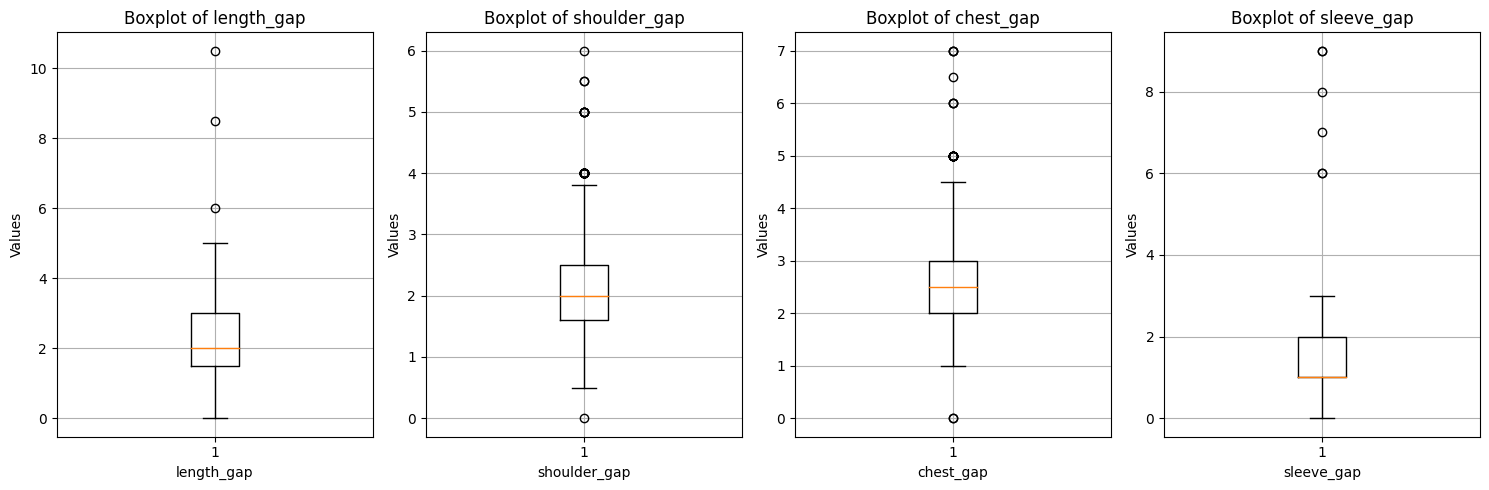

In [ ]:
# gap 컬럼들을 리스트로 저장
gap_columns = ['length_gap', 'shoulder_gap', 'chest_gap', 'sleeve_gap']

plt.figure(figsize=(15, 5))

# 각 gap 컬럼에 대해 박스플롯 그리기
for i, column in enumerate(gap_columns, start=1):
    plt.subplot(1, len(gap_columns), i)
    gaps = []
    for vals in gap_all_df[column]:
        gaps.extend(vals)

    # 박스플롯 그리기
    plt.boxplot(gaps)
    plt.xlabel(column)
    plt.ylabel('Values')
    plt.title(f'Boxplot of {column}')
    plt.grid(True)

    # 사분위수 계산
    q1 = np.percentile(gaps, 25)
    q3 = np.percentile(gaps, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # outliers 계산
    small_outliers = [x for x in gaps if x < lower_bound ]
    big_outliers = [x for x in gaps if x > upper_bound]
    num_small_outliers = len(small_outliers)
    num_big_outliers = len(big_outliers)

    # 사분위수와 outliers 개수 출력
    print(f'{column} - Q1: {q1}, Q3: {q3}, IQR: {iqr}')
    print(f'{column} - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')
    print(f'{column} - Number of Small Outliers: {num_small_outliers}')
    print(f'{column} - Number of Big Outliers: {num_big_outliers}')

plt.tight_layout()
plt.show()

In [ ]:
# 사분위수 계산 함수
def calculate_quartiles(values):
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

# 최빈값 계산 함수
def calculate_mode(values):
    if len(values) == 0:
        return None
    freq = Counter(values)
    max_freq = max(freq.values())
    modes = [key for key, value in freq.items() if value == max_freq]
    return modes

# 각 gap의 고유값과 gap들을 계산하는 함수
def calculate_unique_gaps(size_data, index):
    values = sorted([size[index] for size in size_data])
    gaps = [round(values[i+1] - values[i], 2) for i in range(len(values)-1)]
    unique_gaps = calculate_mode(gaps)
    return unique_gaps, gaps

# 각 상품별로 gap을 계산하고 평균을 내는 함수
def add_gap_columns(row, lower_bounds, upper_bounds):
    size_data = row['size_total']

    length_mode, length_gaps = calculate_unique_gaps(size_data, 1)
    shoulder_mode, shoulder_gaps = calculate_unique_gaps(size_data, 2)
    chest_mode, chest_gaps = calculate_unique_gaps(size_data, 3)
    sleeve_mode, sleeve_gaps = calculate_unique_gaps(size_data, 4)

    if len(length_mode) > 1:
        filtered_length_gaps = [gap for gap in length_gaps if lower_bounds[0] <= gap <= upper_bounds[0]]
        length_mode = calculate_mode(filtered_length_gaps)

    if len(shoulder_mode) > 1:
        filtered_shoulder_gaps = [gap for gap in shoulder_gaps if lower_bounds[1] <= gap <= upper_bounds[1]]
        shoulder_mode = calculate_mode(filtered_shoulder_gaps)

    if len(chest_mode) > 1:
        filtered_chest_gaps = [gap for gap in chest_gaps if lower_bounds[2] <= gap <= upper_bounds[2]]
        chest_mode = calculate_mode(filtered_chest_gaps)

    if len(sleeve_mode) > 1:
        filtered_sleeve_gaps = [gap for gap in sleeve_gaps if lower_bounds[3] <= gap <= upper_bounds[3]]
        sleeve_mode = calculate_mode(filtered_sleeve_gaps)

    # 평균값 계산 후 소수점 둘째 자리까지 반올림
    row['length_gap_mode'] = round(np.mean(length_mode), 2) if length_mode else None
    row['shoulder_gap_mode'] = round(np.mean(shoulder_mode), 2) if shoulder_mode else None
    row['chest_gap_mode'] = round(np.mean(chest_mode), 2) if chest_mode else None
    row['sleeve_gap_mode'] = round(np.mean(sleeve_mode), 2) if sleeve_mode else None

    return row

# 각 gap 컬럼에 대해 사분위수 계산
gap_columns = ['length_gap', 'shoulder_gap', 'chest_gap', 'sleeve_gap']
lower_bounds = []
upper_bounds = []

for column in gap_columns:
    all_gaps = []
    for vals in gap_all_df[column]:
        all_gaps.extend(vals)
    lower_bound, upper_bound = calculate_quartiles(all_gaps)
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)

# 데이터프레임에 새로운 컬럼 추가('gap_mode_not_outlier_df'로 지정)
gap_mode_not_outlier_df = size_total_df.apply(lambda row: add_gap_columns(row, lower_bounds, upper_bounds), axis=1)

In [ ]:
gap_mode_not_outlier_df.shape

(296, 6)

In [ ]:
gap_mode_not_outlier_df.head(2)

,goodsNo,size_total,length_gap_mode,shoulder_gap_mode,chest_gap_mode,sleeve_gap_mode
0,394585,"[[M, 73.0, 56.0, 58.0, 60.0], [L, 76.0, 60.0, ...",3.0,4.0,2.0,2.0
1,394608,"[[L, 76.0, 60.0, 61.0, 62.0], [M, 73.0, 56.0, ...",3.0,4.0,3.0,2.0


In [ ]:
# 사이즈 재구성을 위한 df('cal_df'로 지정)
cal_new_size_df = pd.merge(gap_mode_not_outlier_df, b_s_sum_df, on='goodsNo', how='inner')

In [ ]:
cal_new_size_df.head(2)

,goodsNo,size_total,length_gap_mode,shoulder_gap_mode,chest_gap_mode,sleeve_gap_mode,length_b_s,shoulder_b_s,chest_b_s,sleeve_b_s
0,394585,"[[M, 73.0, 56.0, 58.0, 60.0], [L, 76.0, 60.0, ...",3.0,4.0,2.0,2.0,0.013333,0.000000,0.000000,0.03
1,394608,"[[L, 76.0, 60.0, 61.0, 62.0], [M, 73.0, 56.0, ...",3.0,4.0,3.0,2.0,0.016667,0.006667,0.003333,0.02


In [ ]:
# 새로운 컬럼을 추가하는 함수 정의
def calculate_new_size_total(row):
    size_total = row['size_total']
    length_gap_mode = row['length_gap_mode']
    shoulder_gap_mode = row['shoulder_gap_mode']
    chest_gap_mode = row['chest_gap_mode']
    sleeve_gap_mode = row['sleeve_gap_mode']
    length_b_s = row['length_b_s']
    shoulder_b_s = row['shoulder_b_s']
    chest_b_s = row['chest_b_s']
    sleeve_b_s = row['sleeve_b_s']

    # 각 리스트 안의 리스트들에 대해 계산
    new_size_total = []
    for size in size_total:
        size_label = size[0]  # 첫 번째 값은 사이즈 레이블
        length = size[1] + (length_gap_mode * length_b_s) if len(size) > 1 else size[1]
        shoulder = size[2] + (shoulder_gap_mode * shoulder_b_s) if len(size) > 2 else size[2]
        chest = size[3] + (chest_gap_mode * chest_b_s) if len(size) > 3 else size[3]
        sleeve = size[4] + (sleeve_gap_mode * sleeve_b_s) if len(size) > 4 else size[4]
        new_size = [size_label, length, shoulder, chest, sleeve]
        new_size_total.append(new_size)

    # 새로운 컬럼에 할당
    row['size_new_total'] = new_size_total
    return row

# apply 함수를 사용하여 새로운 컬럼 추가('new_size_df'지정)
new_size_df = cal_new_size_df.apply(calculate_new_size_total, axis=1)

In [ ]:
new_size_df.head(2)

,goodsNo,size_total,length_gap_mode,shoulder_gap_mode,chest_gap_mode,sleeve_gap_mode,length_b_s,shoulder_b_s,chest_b_s,sleeve_b_s,size_new_total
0,394585,"[[M, 73.0, 56.0, 58.0, 60.0], [L, 76.0, 60.0, ...",3.0,4.0,2.0,2.0,0.013333,0.000000,0.000000,0.03,"[[M, 73.04, 56.0, 58.0, 60.06], [L, 76.04, 60...."
1,394608,"[[L, 76.0, 60.0, 61.0, 62.0], [M, 73.0, 56.0, ...",3.0,4.0,3.0,2.0,0.016667,0.006667,0.003333,0.02,"[[L, 76.05, 60.026666666666664, 61.01, 62.04],..."


In [ ]:
new_size_df.shape

(296, 11)

In [ ]:
selected_columns = ['goodsNo','size_total', 'length_gap_mode','length_b_s', 'size_new_total']
new_size_df[selected_columns]

,goodsNo,size_total,length_gap_mode,length_b_s,size_new_total
0,394585,"[[M, 73.0, 56.0, 58.0, 60.0], [L, 76.0, 60.0, ...",3.0,0.013333,"[[M, 73.04, 56.0, 58.0, 60.06], [L, 76.04, 60...."
1,394608,"[[L, 76.0, 60.0, 61.0, 62.0], [M, 73.0, 56.0, ...",3.0,0.016667,"[[L, 76.05, 60.026666666666664, 61.01, 62.04],..."
2,404474,"[[M, 72.5, 51.0, 55.5, 59.0], [XL, 76.5, 55.0,...",2.0,-0.003356,"[[M, 72.49328859060402, 51.033557046979865, 55..."
3,404482,"[[M, 72.5, 51.0, 55.5, 59.0], [XL, 76.5, 55.0,...",2.0,0.003509,"[[M, 72.50701754385965, 51.00701754385965, 55...."
4,407066,"[[XXL, 76.5, 54.0, 62.5, 63.0], [M, 72.5, 49.5...",1.5,0.013333,"[[XXL, 76.52, 54.0, 62.5, 63.01], [M, 72.52, 4..."
...,...,...,...,...,...
291,3877002,"[[M, 78.0, 58.5, 68.0, 61.0], [L, 80.0, 60.5, ...",2.0,0.010033,"[[M, 78.0200668896321, 58.5066889632107, 67.99..."
292,3884711,"[[M, 75.0, 55.0, 59.0, 59.5], [XL, 79.0, 59.0,...",2.0,0.000000,"[[M, 75.0, 55.0, 59.0, 59.50333333333333], [XL..."
293,4047283,"[[S, 68.0, 47.0, 64.0, 23.0], [M, 70.0, 49.0, ...",2.0,0.013423,"[[S, 68.02684563758389, 47.0, 64.0067114093959..."
294,4073506,"[[L, 79.0, 58.0, 66.0, 58.0], [XL, 81.0, 60.0,...",2.0,0.021818,"[[L, 79.04363636363637, 58.0, 66.0, 58.0], [XL..."


# new_size_df에서 'size_new_total'을 기존 df에 적용(새로 재구성된 사이즈 컬럼 추가)

In [ ]:
# 새로운 컬럼을 추가할 데이터프레임 생성('size_check'는 테스트용/추후에 drop가능)
df['size_check'] = None
df['length_new'] = None
df['shoulder_new'] = None
df['chest_new'] = None
df['sleeve_new'] = None

# 'goodsNo'와 'size' 정보가 일치하는 경우 해당 값을 새로운 컬럼에 추가
for i, row in df.iterrows():
    goods_no_match = row['goodsNo']
    size_match = row['size']
    size_total_cal_list = new_size_df[new_size_df['goodsNo'] == goods_no_match]['size_new_total'].values
    if len(size_total_cal_list) > 0:
        size_total_cal = size_total_cal_list[0]
        for sizes in size_total_cal:
            if sizes[0] == size_match:
                df.at[i, 'size_check'] = sizes[0]
                df.at[i, 'length_new'] = sizes[1]
                df.at[i, 'shoulder_new'] = sizes[2]
                df.at[i, 'chest_new'] = sizes[3]
                df.at[i, 'sleeve_new'] = sizes[4]
                break

In [ ]:
df.shape

(87959, 32)

In [ ]:
df.columns

Index(['review', 'id', 'goodsNo', 'brandNameEng', 'goodsName', 'imageUrl',
       'reviewScore', 'typeClass', 'cate', 'size', 'length', 'shoulder',
       'chest', 'sleeve', 'date', 'grade', 'gender', 'height', 'weight',
       'total_b_s', 'length_b_s', 'shoulder_b_s', 'chest_b_s', 'sleeve_b_s',
       'sum_b_s', 'predicted_typeClass', 'actual_typeClass', 'size_check',
       'length_new', 'shoulder_new', 'chest_new', 'sleeve_new'],
      dtype='object')

In [ ]:
df.head(2)

,review,id,goodsNo,brandNameEng,goodsName,imageUrl,reviewScore,typeClass,cate,size,...,chest_b_s,sleeve_b_s,sum_b_s,predicted_typeClass,actual_typeClass,size_check,length_new,shoulder_new,chest_new,sleeve_new
0,"가, 겨 대비 품질 이 괜찮습니다 재구매, 의사 있습니다",안목있는칠레모던,2151608,BASIC HOUSE,[UNI]순면 고밀도 긴팔 티셔츠2팩 LATS0102,https://image.msscdn.net/thumbnails/images/goo...,95,0,longs,105,...,0,0,0,0,0,105,73.033784,51.0,57.508446,64.525338
1,"가, 기본 아이템 으로 좋다고 하더니, 아주 마음 에 들어요, 네이비 도 정직한 네...",바람직한검정힐,3603793,LEE,[22FW] 빅 트위치 루즈핏 맨투맨 NAVY,https://image.msscdn.net/thumbnails/images/goo...,97,1,man2man,M,...,0,0,0,0,1,M,69.013559,54.0,59.00678,59.0


In [ ]:
selected_columns = ['goodsNo','size', 'length', 'shoulder', 'chest', 'sleeve', 'size_check', 'length_new', 'shoulder_new', 'chest_new', 'sleeve_new']
df[selected_columns]

,goodsNo,size,length,shoulder,chest,sleeve,size_check,length_new,shoulder_new,chest_new,sleeve_new
0,2151608,105,73.0,51.0,57.5,64.5,105,73.033784,51.0,57.508446,64.525338
1,3603793,M,69.0,54.0,59.0,59.0,M,69.013559,54.0,59.00678,59.0
2,3134802,XXXL,74.5,60.5,66.5,59.0,XXXL,74.5,60.5,66.5,59.0
3,2995104,S,65.0,65.0,66.0,52.0,S,65.0,65.0,66.006667,51.993333
5,1190282,XL,74.0,51.5,59.0,60.5,XL,74.0,51.5,59.0,60.5
...,...,...,...,...,...,...,...,...,...,...,...
94520,3481226,L,72.3,50.0,57.0,59.0,L,72.3,50.0,57.0,58.996587
94521,3481226,M,70.8,48.5,54.5,58.0,M,70.8,48.5,54.5,57.996587
94522,3481227,XL,73.8,51.5,59.5,60.0,XL,73.810204,51.5,59.5,60.003401
94523,3481226,L,72.3,50.0,57.0,59.0,L,72.3,50.0,57.0,58.996587


In [ ]:
# size와 size_check가 다른 케이스 필터링
different_size_cases = df[selected_columns][df['size'] != df['size_check']]

# 테스트용
different_size_cases

,goodsNo,size,length,shoulder,chest,sleeve,size_check,length_new,shoulder_new,chest_new,sleeve_new


In [ ]:
# csv파일 저장
df.to_csv('predicted_size_df.csv', index=False)